<a href="https://colab.research.google.com/github/KhaingLae/TensorFlow_DeepLearning_Bootcamp/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 🪐 🔥 📚

The purpose of this book is to build an NLP model to make reading medical abstracts easier.

The paper we're replicationg (the source of the dataset that we'll be using) is avaliable here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best result is available here: https://arxiv.org/pdf/1612.05251

## Confirm access to GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-56a588ec-84d8-57eb-6296-71941e94e8a6)


In [ ]:
# downgrade version for compatibiltiy
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
!pip install --upgrade pandas

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
print(pd.__version__)

2.2.3


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset the used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced with @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data to visualize.

So with that in mind, let's write a function to read all of the lines in target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings containing the lines of text in the file.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # Read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look..

How I this our data would be best represented....

Let's write a function to perform the following steps:

* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:

  * If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
      * Keep count of the number of lines in a sample.

  * If the line begins with \n mark it as the end of an abstract sample.
      * Keep count of the total lines in a sample.

  * Record the text before the \t as the label of the line.

  * Record the text after the \t as the text of the line.

* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * "line_number" - the position of the line in the abstract (e.g. 3).
  * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  * "text" - the text of the line in the abstract.
  * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.
Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
  ```

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  Return a list of dictionaries of abstract line data.

  Takes in filename, read it contents  and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples =[]

  for line in input_lines:
    if line.startswith("###"): # check to see if it's an ID Line
      abstract_id = line
      # print(f"new abstract begins : {abstract_id} \n")
      abstract_lines = "" # reset the abstract string line is ID line
    elif line.isspace(): # check to see line is new line
      # print("new line \n")
      abstract_line_split = abstract_lines.splitlines()
      # print(f"abstract_line_split : {abstract_line_split}")
      # Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the line on the tab
        line_data["target"] = target_text_split[0]
        # print(f"target : {target_text_split[0] } \n")
        line_data["text"]=target_text_split[1].lower()
        # print(f"text : {target_text_split[1] } \n")
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_number(data_dir+"train.txt")
val_samples = preprocess_text_with_line_number(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_number(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 324 ms, sys: 94.9 ms, total: 419 ms
Wall time: 420 ms


In [ ]:
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into DataFrame..

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

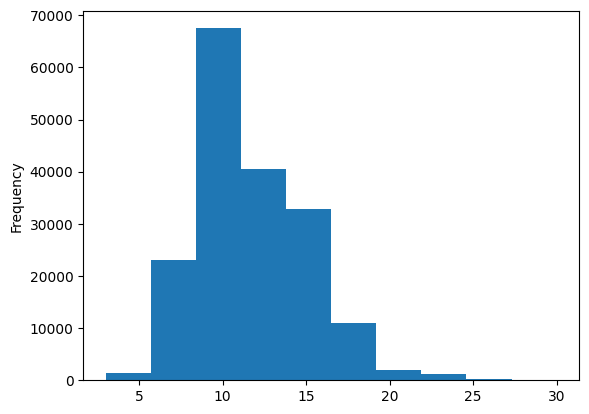

In [ ]:
train_df.total_lines.plot.hist()

### Get list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences =train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 first lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labesl (ML model requires numeric labels)

In [ ]:
# One hote encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_label_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_label_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# get class names and number of classes in LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 5
Class names: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Starting a series of modelling experiments....

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model on validataion dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-04-24 10:48:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-24 10:48:28 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens =[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

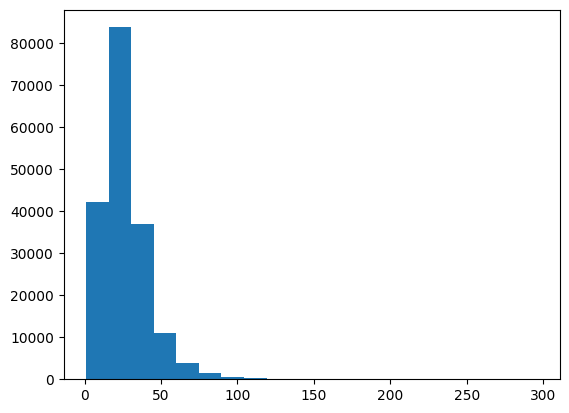

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our word to numbers.

In [ ]:
# How many words in our vacb? (Taken from table 2 in: https://arxiv.org/pdf/1710.06071 )
max_tokens =68000

In [ ]:
from tensorflow.keras.layers import TextVectorization
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Target sentence: {target_sentence}")
print(f"\nLength of target sentence: {len(target_sentence.split())}")
print(f"\nVectorized target sentence: ")
text_vectorizer([target_sentence])

Target sentence: however , it is not known whether web-based interventions may also be effective in preventing the onset of mdd .

Length of target sentence: 20

Vectorized target sentence: 


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 140,  185,   20,   31,  682,  180, 1291,  265,   91,  138,   36,
         137,    5, 1126,    2,  779,    4, 2096,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
# How many words in our training vacalbulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common 5 words: {rct_20k_text_vocab[:5]}")
print(f"Least common 5 words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common 5 words: ['', '[UNK]', 'the', 'and', 'of']
Least common 5 words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=max_tokens,
                               output_dim=128,
                               mask_zero = True, # should set mask_zero = True because our embedding includes many zeros that is meaningless
                               input_length=output_seq_len,
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization: {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nSentence after vectorization (before embedding): {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nSentence after embedding: {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: however , it is not known whether web-based interventions may also be effective in preventing the onset of mdd .

Sentence after vectorization (before embedding): [[ 140  185   20   31  682  180 1291  265   91  138   36  137    5 1126
     2  779    4 2096    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: [[[-0.04197128 -0.0466321   0.03304586 ...  0.0412198  -0.01508986
   -0.01239742]
  [ 0.01575749  0.03650173 -0.04027903 ... -0.01079786  0.00394074
    0.03732213]
  [ 0.03446997  0.01642866 -0.01189113 ...  0.04224619  0.02411575
   -0.00080229]
  ...
  [-0.00169548 -0.04996102 -0.03111024 ...  0.03256052 -0.02280395
   -0.01111649]
  [-0.00169548 -0.04996102 -0.03111024 ...  0.03256052 -0.02280395
   -0.01111649]
  [-0.00169548 -0.04996102 -0.03111024 ...  0.03256052 -0.02280395
   -0.

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API

*   https://www.tensorflow.org/guide/data_performance
*   https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_label_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_label_one_hot.shape, train_label_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs =layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # softmax of multiple category
model_1 = tf.keras.Model(inputs, outputs, name="Model_1_ConvModel")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "Model_1_ConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8704000   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                 

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 102s 180ms/step - loss: 0.9493 - accuracy: 0.6214 - val_loss: 0.7216 - val_accuracy: 0.7251
Epoch 2/3
562/562 [==============================] - 96s 171ms/step - loss: 0.6851 - accuracy: 0.7465 - val_loss: 0.6602 - val_accuracy: 0.7633
Epoch 3/3
562/562 [==============================] - 95s 169ms/step - loss: 0.6377 - accuracy: 0.7670 - val_loss: 0.6146 - val_accuracy: 0.7783


In [ ]:
# Evaluate on validation data set
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6147 - accuracy: 0.7812


[0.6146867275238037, 0.7812127470970154]

In [ ]:
# Make predictions (our model prediction probabilities for each class)
model_1_pred_probs= model_1.predict(valid_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 3s 4ms/step


(array([[4.8266476e-01, 1.5677443e-01, 7.5979866e-02, 2.4824010e-01,
         3.6340993e-02],
        [4.5998520e-01, 2.1607442e-01, 1.6595742e-02, 2.9751399e-01,
         9.8306546e-03],
        [1.9190046e-01, 2.1397656e-02, 3.0141133e-03, 7.8359747e-01,
         9.0286347e-05],
        [6.2367531e-06, 2.1104632e-04, 9.7840631e-01, 7.8691819e-06,
         2.1368627e-02],
        [1.8099787e-03, 4.5572639e-02, 2.9422829e-01, 1.7009468e-03,
         6.5668815e-01],
        [2.6409440e-02, 3.2079209e-02, 5.7578242e-01, 1.0565226e-02,
         3.5516381e-01],
        [3.8298234e-04, 2.8967047e-03, 2.4824920e-01, 1.6575886e-04,
         7.4830538e-01],
        [3.2903571e-02, 3.2380324e-02, 6.2410986e-01, 1.5047353e-02,
         2.9555893e-01],
        [8.4916129e-13, 1.9383853e-08, 1.2281374e-07, 2.0431908e-13,
         9.9999982e-01],
        [9.6102059e-03, 7.1811128e-01, 5.4231308e-02, 3.0583924e-02,
         1.8746319e-01]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.12127631404739,
 'precision': 0.7767741889581685,
 'recall': 0.7812127631404739,
 'f1': 0.7778621141161041}

In [ ]:
baseline_results

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder:
https://tfhub.dev/google/universal-sentence-encoder/4 (Old)

https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2 (Now)

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.


In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"\nEmbedded sentence: {use_embedded_sentence[0][:30]}")
print(f"Embedded sentence shape: {len(use_embedded_sentence[0])}")

Random sentence: there were no differences in the clinical baseline data between the two groups .

Embedded sentence: [-0.01172623 -0.04983565 -0.05482208  0.02820718  0.00720207 -0.02745322
  0.04319368 -0.01878778 -0.05184951  0.0774059   0.07883187  0.01073416
  0.01717789  0.0426521  -0.07075185 -0.01533683 -0.08151025 -0.03646671
 -0.02048904  0.01069649 -0.00967185  0.01229666 -0.05039459  0.02974491
 -0.03240478 -0.03393791  0.00204414  0.08558025  0.0721909  -0.04284219]
Embedded sentence shape: 512


### Building and Fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
# pretrained_embedding = tf_hub_embedding_layer(inputs) # get error
pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 9ms/step - loss: 0.9135 - accuracy: 0.6534 - val_loss: 0.7984 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7698 - accuracy: 0.7013 - val_loss: 0.7573 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7536 - accuracy: 0.7122 - val_loss: 0.7404 - val_accuracy: 0.7151


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.7423 - accuracy: 0.7141


[0.7422820329666138, 0.7141202092170715]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 6s 6ms/step


array([[4.4549209e-01, 3.5272565e-01, 2.8017736e-03, 1.9054425e-01,
        8.4362011e-03],
       [3.5294050e-01, 4.7841170e-01, 3.8413038e-03, 1.6104549e-01,
        3.7611302e-03],
       [2.2301574e-01, 1.6376920e-01, 1.7815677e-02, 5.5413061e-01,
        4.1268695e-02],
       [1.4247600e-02, 4.1913483e-02, 8.3548468e-01, 8.2459571e-03,
        1.0010828e-01],
       [3.6654532e-02, 2.1820046e-01, 2.4933776e-01, 1.4975325e-02,
        4.8083198e-01],
       [1.3452759e-03, 2.8976684e-03, 6.7653465e-01, 1.4791467e-04,
        3.1907442e-01],
       [2.0443390e-03, 3.5663850e-03, 6.6761625e-01, 1.3314901e-03,
        3.2544157e-01],
       [4.8087272e-03, 2.1588370e-02, 4.7311005e-01, 1.1196107e-03,
        4.9937329e-01],
       [8.1078481e-04, 8.0329534e-03, 2.1484889e-02, 1.0868015e-03,
        9.6858460e-01],
       [1.3241795e-01, 7.0481282e-01, 1.9837551e-02, 8.0216579e-02,
        6.2715232e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [ ]:
# Calculate results from TF Hub pretrained embedding results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.41202171322654,
 'precision': 0.7146388441193902,
 'recall': 0.7141202171322654,
 'f1': 0.7111496427834254}

In [ ]:
baseline_results

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.



### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

In [ ]:
# Make functions to split sentences into characters
def split_chars(text):
  return  " ".join(list(text))

In [ ]:
# Text splitting non-character level senquenst into characters
split_chars(random_train_sentence)

't h e r e   w e r e   n o   d i f f e r e n c e s   i n   t h e   c l i n i c a l   b a s e l i n e   d a t a   b e t w e e n   t h e   t w o   g r o u p s   .'

In [ ]:
# Split sequence_level data splits into character_level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
chars_len =[len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

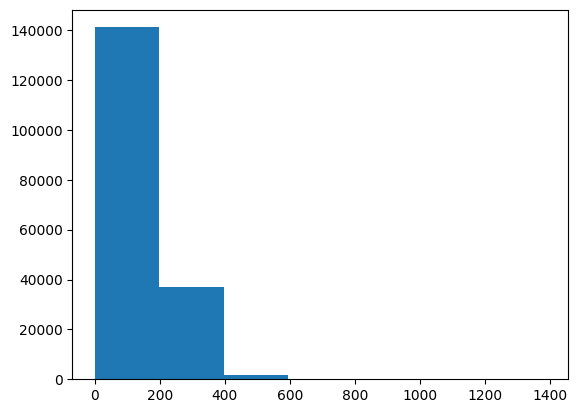

In [ ]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=7)

In [ ]:
# Find what character lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = Out of Vacab (UNK))
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,
                                    name="char_vectorizer")


In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least cneommon characters: {char_vocab[-5:]}")

# Output below is standardzation No

Number of different characters: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least cneommon characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least cneommon characters: {char_vocab[-5:]}")

# Output below is standardzation default

Number of different characters: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least cneommon characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n{vectorized_chars}")
print(f"\nLength of vectorized_chars: {len(vectorized_chars[0])}")

Charified text: 
t h e   i n c r e a s e   i n   n u m b e r s   o f   p a t i e n t s   r e q u i r i n g   o r a l   a n t i - c o a g u l a t i o n   t e s t i n g   i n   o u t p a t i e n t   c l i n i c s   h a s   f o c u s e d   a t t e n t i o n   o n   a l t e r n a t i v e   f l e x i b l e   s y s t e m s   o f   a n t i - c o a g u l a t i o n   m a n a g e m e n t   .

Length of random_train_chars: 367

Vectorized chars: 
[[ 3 13  2  4  6 11  8  2  5  9  2  4  6  6 16 15 22  2  8  9  7 17 14  5
   3  4  2  6  3  9  8  2 26 16  4  8  4  6 18  7  8  5 12  5  6  3  4 11
   7  5 18 16 12  5  3  4  7  6  3  2  9  3  4  6 18  4  6  7 16  3 14  5
   3  4  2  6  3 11 12  4  6  4 11  9 13  5  9 17  7 11 16  9  2 10  5  3
   3  2  6  3  4  7  6  7  6  5 12  3  2  8  6  5  3  4 21  2 17 12  2 24
   4 22 12  2  9 19  9  3  2 15  9  7 17  5  6  3  4 11  7  5 18 16 12  5
   3  4  7  6 15  5  6  5 18  2 15  2  6  3  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  

## Creating a character-level embedding

In [ ]:
# Create a char level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of differen characters
                              output_dim=25, # this is the size of the chard embedding in the paper
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our char embedding layer
print(f"Charified text: \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars: \n{char_embed_example}\n")
print(f"Embedded chars shape: {char_embed_example.shape}")

Charified text: 
t h e   i n c r e a s e   i n   n u m b e r s   o f   p a t i e n t s   r e q u i r i n g   o r a l   a n t i - c o a g u l a t i o n   t e s t i n g   i n   o u t p a t i e n t   c l i n i c s   h a s   f o c u s e d   a t t e n t i o n   o n   a l t e r n a t i v e   f l e x i b l e   s y s t e m s   o f   a n t i - c o a g u l a t i o n   m a n a g e m e n t   .

Embedded chars: 
[[[-0.02460636 -0.04704851  0.00246201 ... -0.02843695  0.01671871
   -0.04760454]
  [ 0.00377967  0.01024264 -0.0356228  ... -0.04723983  0.03076224
   -0.0086055 ]
  [-0.0369146   0.0136454  -0.01328452 ... -0.02845627  0.01516533
    0.03909225]
  ...
  [ 0.02807038  0.00793861 -0.00878309 ... -0.03754333 -0.02898662
   -0.00376033]
  [ 0.02807038  0.00793861 -0.00878309 ... -0.03754333 -0.02898662
   -0.00376033]
  [ 0.02807038  0.00793861 -0.00878309 ... -0.03754333 -0.02898662
   -0.00376033]]]

Embedded chars shape: (1, 290, 25)


### Building a Conv1D model to fit on character level embedding

In [ ]:
# Make a Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                               steps_per_epoch=int(0.1*len(train_char_dataset)),

                                epochs=3,
                               validation_data=val_char_dataset,
                               validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 1.2708 - accuracy: 0.4825 - val_loss: 1.0657 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 1.0210 - accuracy: 0.5932 - val_loss: 0.9491 - val_accuracy: 0.6287
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.9315 - accuracy: 0.6327 - val_loss: 0.8701 - val_accuracy: 0.6686


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

945/945 [==============================] - 4s 4ms/step


array([[2.3288627e-01, 2.9210544e-01, 1.0309569e-01, 3.0682367e-01,
        6.5088928e-02],
       [1.5197213e-01, 6.4070356e-01, 1.6905785e-02, 1.3462313e-01,
        5.5795342e-02],
       [2.4669896e-01, 2.1163324e-01, 1.2477519e-01, 3.6831701e-01,
        4.8575643e-02],
       [1.0173301e-02, 1.7960824e-02, 8.8196164e-01, 1.6193355e-02,
        7.3710807e-02],
       [6.6797147e-03, 2.9281780e-02, 4.9670208e-01, 4.6913563e-03,
        4.6264502e-01],
       [5.2983908e-04, 1.1516203e-03, 8.9071798e-01, 1.7003452e-04,
        1.0743054e-01],
       [4.5174868e-03, 8.0259573e-03, 6.5319312e-01, 1.8404225e-03,
        3.3242288e-01],
       [1.9234882e-01, 4.2979851e-01, 8.1113420e-02, 1.8552874e-01,
        1.1121057e-01],
       [2.5268453e-03, 1.0986410e-02, 8.6024977e-02, 1.5319166e-03,
        8.9892972e-01],
       [1.2505890e-01, 1.8789256e-01, 2.9016429e-01, 1.4977817e-01,
        2.4710599e-01]], dtype=float32)

In [ ]:
# Convert predictions probabilities to class labesl
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 1, 3, 2, 2, 2, 2, 1, 4, 2])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results= calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_pred)
model_3_results

{'accuracy': 65.89765656030715,
 'precision': 0.6517489498754561,
 'recall': 0.6589765656030716,
 'f1': 0.6476904856147123}

## Model 4: Combining pretrained token embeddings + characters embedding

1. Create a token-level embedding model (similar model_1)
2. Create a character-level embedding model (simliar to model_3 with a slight modification)
3. Combine 1 & 2 with a concatenate ('layers.Concatenate')
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of paper.
5. Construct a model which takes token and character-level sequences as inputs and produce sequence lable probabilities as output


In [ ]:
# 1. Setup token inputs/mode
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
# char_embeddings = tf_hub_embedding_layer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-lstm shown in Figure 1 of paper
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Combine token and char model into final model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs= output_layer,
                         name="model_4_token_char_embedding")

In [ ]:
model_4.summary()

Model: "model_4_token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['t

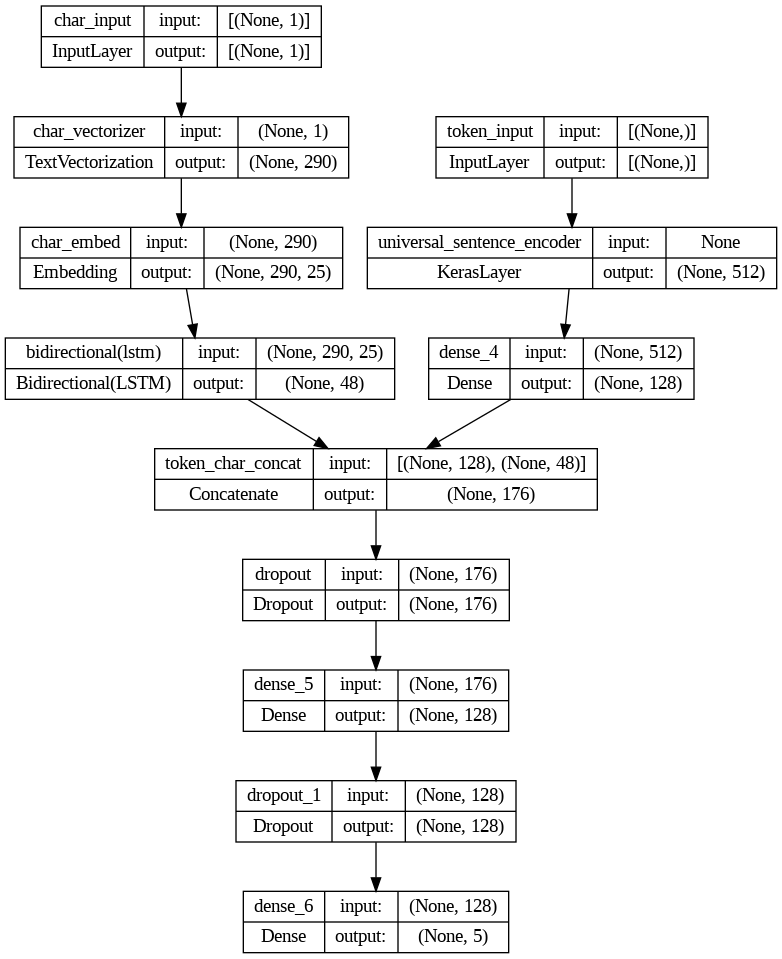

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model=model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # Section 4.2 of paper uses SGD
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 167s 282ms/step - loss: 0.9798 - accuracy: 0.6123 - val_loss: 0.7695 - val_accuracy: 0.7088
Epoch 2/3
562/562 [==============================] - 150s 267ms/step - loss: 0.7985 - accuracy: 0.6929 - val_loss: 0.7144 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 147s 261ms/step - loss: 0.7734 - accuracy: 0.7056 - val_loss: 0.6884 - val_accuracy: 0.7380


In [ ]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6971 - accuracy: 0.7346


[0.6970943808555603, 0.7345756888389587]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 [==============================] - 53s 52ms/step


array([[4.2014906e-01, 3.5707194e-01, 3.2029210e-03, 2.1359372e-01,
        5.9823575e-03],
       [3.8441375e-01, 4.2839417e-01, 2.6288149e-03, 1.8210706e-01,
        2.4563025e-03],
       [2.8814226e-01, 7.6037049e-02, 5.8147963e-02, 5.5675638e-01,
        2.0916369e-02],
       [1.6610503e-02, 2.6896240e-02, 8.2534641e-01, 1.0435042e-02,
        1.2071180e-01],
       [3.0129068e-02, 8.3808109e-02, 6.3450044e-01, 1.1444602e-02,
        2.4011770e-01],
       [9.0098800e-04, 2.3414947e-03, 6.7908102e-01, 3.5729792e-04,
        3.1731918e-01],
       [1.9518193e-03, 9.6548414e-03, 5.1511794e-01, 1.0623735e-03,
        4.7221306e-01],
       [3.0646545e-03, 2.3447312e-02, 4.7933114e-01, 1.2845922e-03,
        4.9287221e-01],
       [5.6081108e-04, 1.0570382e-02, 3.2411676e-02, 3.5255679e-04,
        9.5610446e-01],
       [2.4532029e-01, 4.9949360e-01, 4.0134136e-02, 1.3467543e-01,
        8.0376461e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 4, 4, 1])>

In [ ]:
# get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.45756652985568,
 'precision': 0.7347214752511226,
 'recall': 0.7345756652985569,
 'f1': 0.7326508617993077}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 Note: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

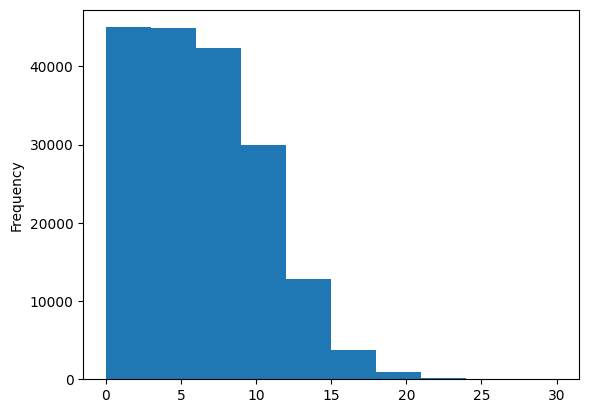

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one_hot_encoded tensors of our line_number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Let's do the same for total lines feature

In [ ]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

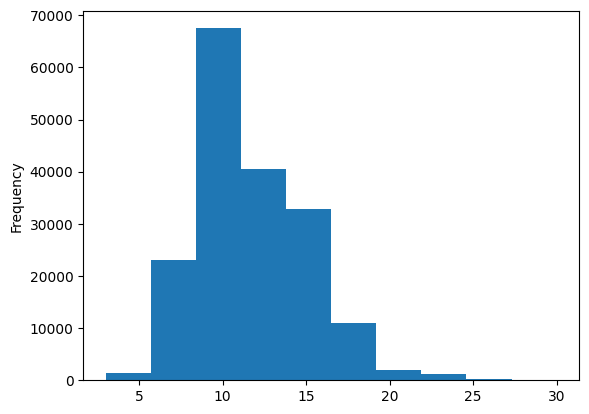

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coveragee of "total_lines" values of 20
np.percentile(train_df["total_lines"], 98) # 98% of coverage

20.0

In [ ]:
# Use TensorFlow to create one_hot_encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)


### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outpus of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an ouput layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
train_line_numbers_one_hot[0].shape, train_line_numbers_one_hot.dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].shape, train_total_lines_one_hot.dtype

(TensorShape([20]), tf.float32)

In [ ]:
from functools import total_ordering
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. line numbers model
# input, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# Dense layer with 32 units & relu activation
x= layers.Dense(32, activation="relu")(line_number_inputs)
# Combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5.Combine token and char embedding into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combinedd token and char embeddings
tribrid_embedding = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax")(tribrid_embedding)

# 8. Put togelther model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding")


In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['toke

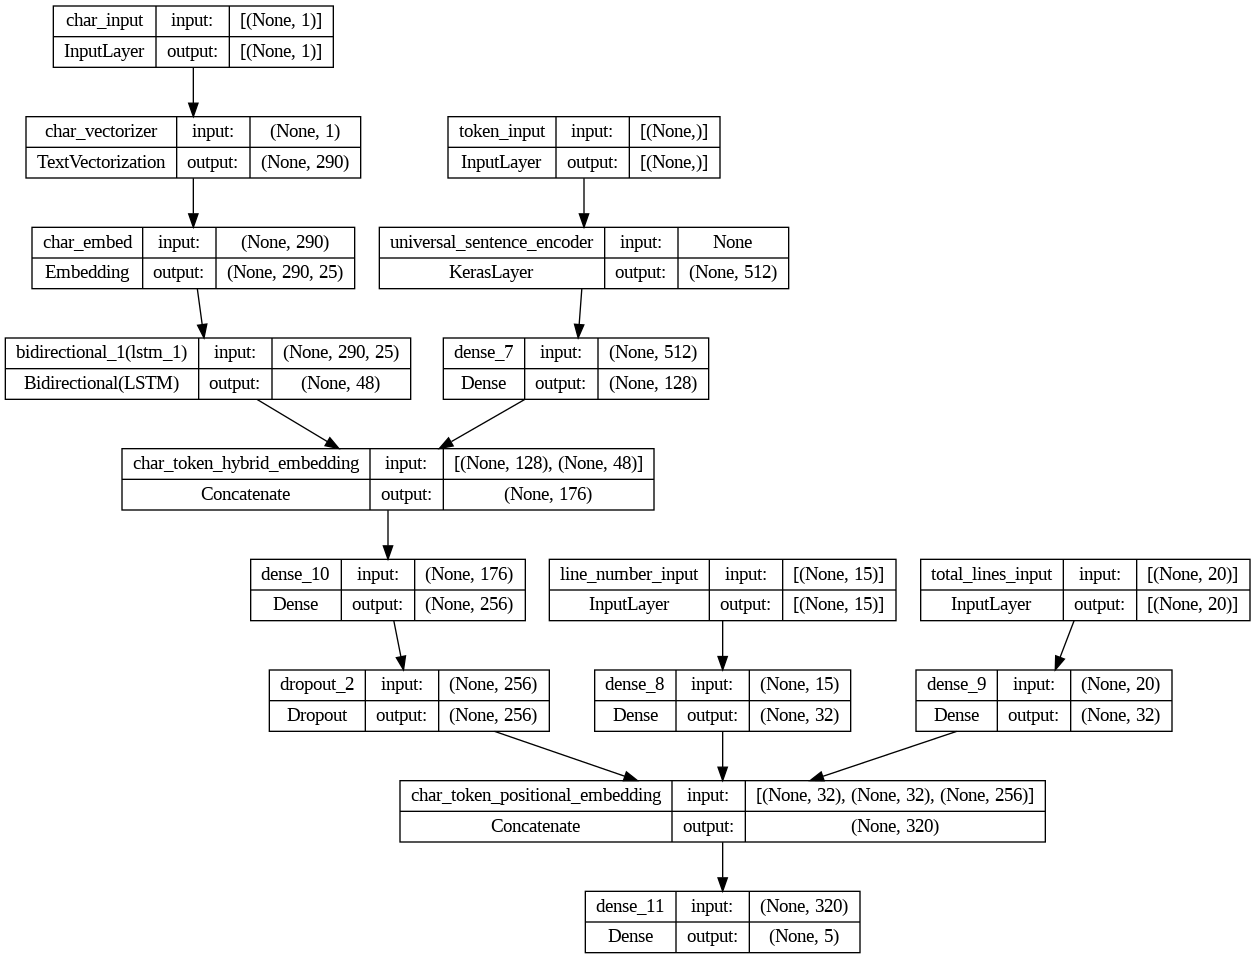

In [ ]:
# Plot model_5 to explore visually..
from tensorflow.keras.utils import plot_model
plot_model(model=model_5, show_shapes=True)

In [ ]:
# Compile token, char and postional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy        (label_smoothing=0.1),  # helps to avoid overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

> 📖 **Resource**:  For more on label smoothing,
https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of dataset)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making prediction with tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 164s 274ms/step - loss: 0.9575 - accuracy: 0.7159 - val_loss: 0.7938 - val_accuracy: 0.8019
Epoch 2/3
562/562 [==============================] - 148s 264ms/step - loss: 0.7699 - accuracy: 0.8173 - val_loss: 0.7473 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 155s 275ms/step - loss: 0.7456 - accuracy: 0.8261 - val_loss: 0.7327 - val_accuracy: 0.8311


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs[:10]

945/945 [==============================] - 57s 58ms/step


array([[0.55372596, 0.0536883 , 0.00239257, 0.38443348, 0.00575957],
       [0.59457856, 0.04792492, 0.02165659, 0.33310756, 0.00273237],
       [0.3528441 , 0.07262101, 0.06288227, 0.4708924 , 0.04076025],
       [0.02329917, 0.0371684 , 0.7743607 , 0.02004662, 0.1451251 ],
       [0.03606449, 0.01981813, 0.801825  , 0.02997141, 0.11232094],
       [0.00531027, 0.02190358, 0.21962029, 0.00490625, 0.74825954],
       [0.00863067, 0.03333953, 0.15940866, 0.00981289, 0.78880817],
       [0.00712267, 0.04793258, 0.12712586, 0.00604309, 0.8117758 ],
       [0.0072231 , 0.03802398, 0.01923331, 0.01241027, 0.92310935],
       [0.02441725, 0.8003093 , 0.01005732, 0.0202004 , 0.14501567]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true= val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 83.30464716006884,
 'precision': 0.832758462954052,
 'recall': 0.8330464716006885,
 'f1': 0.832085975734851}

## Compare model results

In [ ]:
# Combine model results int a dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding":
                                  model_2_results,
                                  "model_3_custom_char_embedding":
                                  model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_post_char_token_embedding": model_5_results})

all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.121276,0.776774,0.781213,0.777862
model_2_pretrained_token_embedding,71.412022,0.714639,0.714120,0.711150
model_3_custom_char_embedding,65.897657,0.651749,0.658977,0.647690
model_4_hybrid_char_token_embedding,73.457567,0.734721,0.734576,0.732651
model_5_post_char_token_embedding,83.304647,0.832758,0.833046,0.832086


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

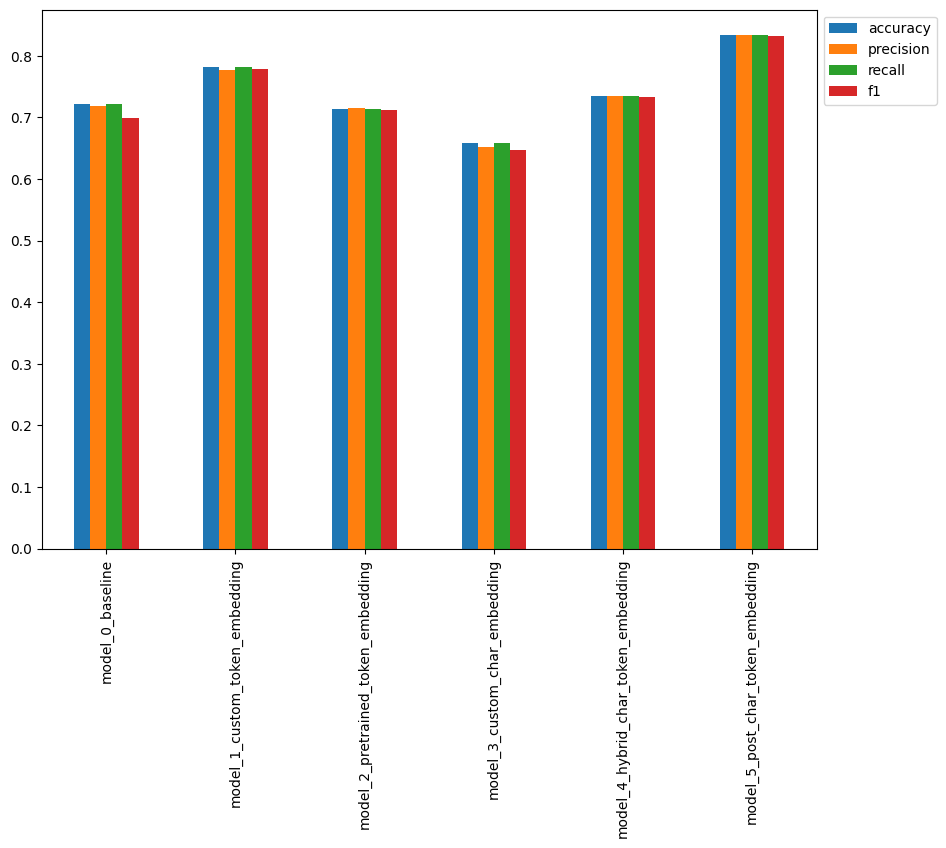

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1,1))

<Axes: >

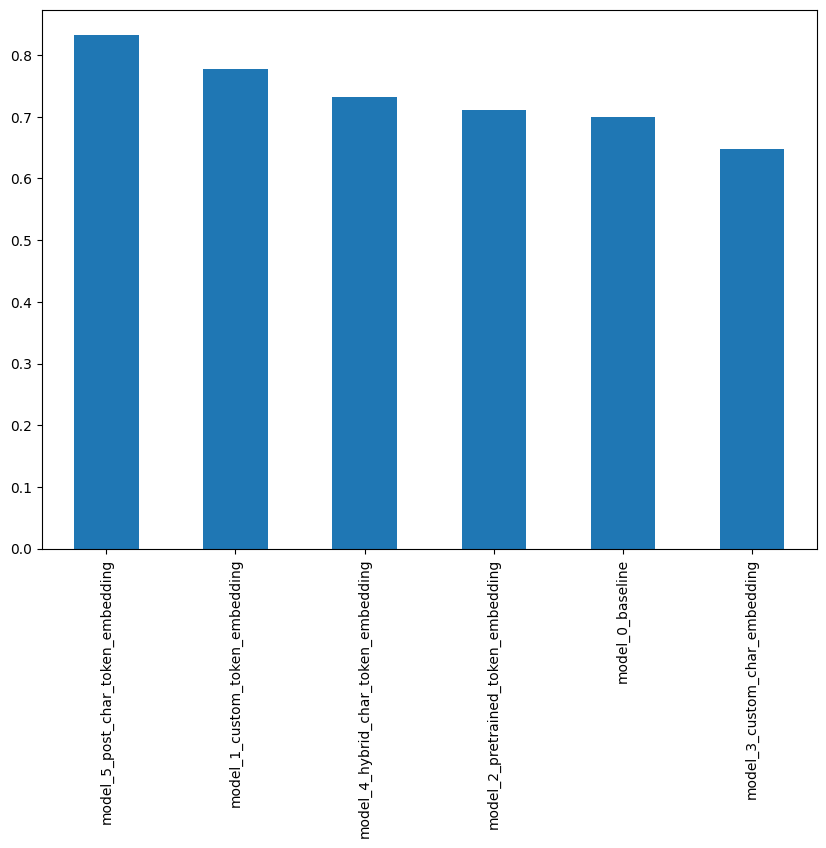

In [ ]:
# Sort models results by f1_score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(figsize=(10,7), kind="bar")

## Save and Load Model

In [ ]:
# Save the best performing model to SavedModel
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
loaded_model.summary()

In [ ]:
# Copy model to Google Drive
!cp -r /content/skimlit_tribrid_model /content/drive/MyDrive/Tensorflow_Course/

## Download and load in a pretrained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization

In [ ]:

# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2025-04-24 11:27:35--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  38.5MB/s    in 24s     

2025-04-24 11:27:59 (37.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [ ]:
model_path="skimlit_gs_model/skimlit_tribrid_model/"

loaded_model= tf.keras.models.load_model(model_path)

In [ ]:
# Evaluate the loaded Google Storage model
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 56s 55ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

In [ ]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 58s 59ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
np.isclose(list(loaded_preds.numpy()), list(model_5_preds.numpy()))

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

### Evaluated model on test dataset

In [ ]:
# Create a test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 67s 71ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results=calculate_results(y_true = test_labels_encoded, y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

### Find most wrong

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[i] for i in test_preds]
test_pred_classes[:10]

CPU times: user 8.34 s, sys: 29 ms, total: 8.37 s
Wall time: 8.48 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

Now we'll enrich our test DataFame with a few values:

* A "prediction" (string) column containing our model's prediction for a given sample.
* A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.
* A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = test_pred_probs.max(axis=1)
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True


In [ ]:
top_100_wrong = test_df[test_df["correct"]==False].sort_values("pred_prob", ascending=False).head(100)
top_100_wrong.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918879,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target:{target}, Pred: {prediction}, Prob: {pred_prob}, Line number : {line_number}, Total lines: {total_lines}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target:CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number : 4, Total lines: 6
Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

----

Target:METHODS, Pred: BACKGROUND, Prob: 0.934973955154419, Line number : 1, Total lines: 11
Text:
pretest-posttest .

----

Target:BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309858679771423, Line number : 0, Total lines: 12
Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

----

Target:RESULTS, Pred: METHODS, Prob: 0.9282615780830383, Line number : 4, Total lines: 13
Text:
the primary endpoint is the cumulative three-year hiv incidence .

----

Target:BACKGROUND, Pred: OBJECTIVE, Prob: 0.9188794493675232, Line number : 0, Total lines: 10
Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) , and to 

### Make example predictions

Okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

Going through various PubMed studies, I managed to find the following unstructured abstract from [RCT of a manualized social treatment for high-functioning autism spectrum disorders](https://pubmed.ncbi.nlm.nih.gov/20232240/).

For each abstract, we'll need to:

1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2025-04-24 11:59:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2025-04-24 11:59:22 (57.6 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.

In [ ]:
# Create sentencizer- Source: https://spacy.io/usage/linguistic-features#sbd

from spacy.lang.en import English
nlp = English() #setup English sentence parser

# new version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in doc.sents] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines


['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

To do so, we can leverage some of the functionality of our preprocess_text_with_line_numbers() function.

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = {}
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample-1
  sample_lines[i] = sample_dict

sample_lines


{0: {'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 1: {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 2: {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 3: {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 4: {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 5: {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_li

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"]for line in sample_lines.values()]

# One hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines.values()]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

In [ ]:
# split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict([test_abstract_line_numbers_one_hot, test_abstract_total_lines_one_hot, tf.constant(abstract_lines), tf.constant(abstract_chars)])
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.23 s, sys: 128 ms, total: 1.36 s
Wall time: 1.27 s


array([[0.2644824 , 0.11054245, 0.01762423, 0.5750656 , 0.03228523],
       [0.06927065, 0.03808297, 0.7078093 , 0.09543163, 0.08940542],
       [0.13772683, 0.04937516, 0.546797  , 0.16341288, 0.10268804],
       [0.0965906 , 0.1711165 , 0.5257438 , 0.07601645, 0.1305327 ],
       [0.04459694, 0.08888116, 0.45675462, 0.04623031, 0.3635369 ],
       [0.03265217, 0.14626434, 0.5174849 , 0.04088318, 0.26271546],
       [0.03290156, 0.17796215, 0.07166827, 0.02870876, 0.6887592 ],
       [0.01843722, 0.13495173, 0.3208418 , 0.03389722, 0.4918721 ]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}:{line}")


OBJECTIVE:This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS:Participants were randomly assigned to treatment or wait-list conditions.
METHODS:Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS:A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS:Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS:Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS:High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS:Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Exercise

### Train Model Longer and use early stop checkpoint

In [ ]:
checkpoint_path= "milestone_project_2_model_5_checkpoint.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint    (filepath=checkpoint_path,
                                                          save_best_only=True,
                                                          monitor="val_accuracy")

In [ ]:
history_model_5_milestone = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)),
                              callbacks=[checkpoint_callback])


Epoch 1/10
562/562 [==============================] - 174s 310ms/step - loss: 0.7356 - accuracy: 0.8320 - val_loss: 0.7223 - val_accuracy: 0.8354
Epoch 2/10
562/562 [==============================] - 184s 327ms/step - loss: 0.7128 - accuracy: 0.8464 - val_loss: 0.7124 - val_accuracy: 0.8457
Epoch 3/10
562/562 [==============================] - 160s 284ms/step - loss: 0.7057 - accuracy: 0.8494 - val_loss: 0.7157 - val_accuracy: 0.8388
Epoch 4/10
562/562 [==============================] - 153s 272ms/step - loss: 0.7169 - accuracy: 0.8449 - val_loss: 0.7086 - val_accuracy: 0.8428
Epoch 5/10
562/562 [==============================] - 182s 323ms/step - loss: 0.7142 - accuracy: 0.8465 - val_loss: 0.7050 - val_accuracy: 0.8484
Epoch 6/10
562/562 [==============================] - 190s 338ms/step - loss: 0.7232 - accuracy: 0.8382 - val_loss: 0.7002 - val_accuracy: 0.8487
Epoch 7/10
562/562 [==============================] - 152s 270ms/step - loss: 0.7092 - accuracy: 0.8463 - val_loss: 0.7023 -

In [ ]:
# early stop callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3)

In [ ]:
history_model_5_milestone = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)),
                              callbacks=[checkpoint_callback, early_stop_callback])

Epoch 1/10
562/562 [==============================] - 156s 278ms/step - loss: 0.6964 - accuracy: 0.8572 - val_loss: 0.6877 - val_accuracy: 0.8557
Epoch 2/10
562/562 [==============================] - 165s 294ms/step - loss: 0.6814 - accuracy: 0.8639 - val_loss: 0.6839 - val_accuracy: 0.8617
Epoch 3/10
562/562 [==============================] - 151s 269ms/step - loss: 0.6801 - accuracy: 0.8589 - val_loss: 0.6955 - val_accuracy: 0.8537
Epoch 4/10
562/562 [==============================] - 153s 272ms/step - loss: 0.6839 - accuracy: 0.8627 - val_loss: 0.6936 - val_accuracy: 0.8491
Epoch 5/10
562/562 [==============================] - 149s 265ms/step - loss: 0.6860 - accuracy: 0.8613 - val_loss: 0.6870 - val_accuracy: 0.8497
Epoch 6/10
562/562 [==============================] - 156s 277ms/step - loss: 0.6962 - accuracy: 0.8533 - val_loss: 0.6859 - val_accuracy: 0.8554


In [ ]:
history_model_5_milestone = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)),
                              callbacks=[early_stop_callback])

Epoch 1/10
562/562 [==============================] - 154s 274ms/step - loss: 0.6794 - accuracy: 0.8666 - val_loss: 0.6830 - val_accuracy: 0.8584
Epoch 2/10
562/562 [==============================] - 156s 278ms/step - loss: 0.6628 - accuracy: 0.8744 - val_loss: 0.6804 - val_accuracy: 0.8590
Epoch 3/10
562/562 [==============================] - 155s 275ms/step - loss: 0.6610 - accuracy: 0.8717 - val_loss: 0.6882 - val_accuracy: 0.8567
Epoch 4/10
562/562 [==============================] - 156s 278ms/step - loss: 0.6663 - accuracy: 0.8734 - val_loss: 0.6891 - val_accuracy: 0.8517
Epoch 5/10
562/562 [==============================] - 159s 282ms/step - loss: 0.6703 - accuracy: 0.8719 - val_loss: 0.6854 - val_accuracy: 0.8531
Epoch 6/10
562/562 [==============================] - 174s 310ms/step - loss: 0.6812 - accuracy: 0.8620 - val_loss: 0.6851 - val_accuracy: 0.8537


### Using GloVe embeddings

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-24 14:14:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 38s  

2025-04-24 14:17:08 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = rct_20k_text_vocab
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
word_index = dict(zip(voc, range(len(voc))))

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])



In [ ]:
# Build the model

inputs =layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
# x = token_embed(x)
x = embedding_layer(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # softmax of multiple category
glove_model= tf.keras.Model(inputs, outputs, name="glove_model")

In [ ]:
glove_model.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [ ]:
# Fit glove_model to the data
history_glove_model = glove_model.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 9ms/step - loss: 0.8010 - acc: 0.7025 - val_loss: 0.7923 - val_acc: 0.7151
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7784 - acc: 0.7152 - val_loss: 0.7751 - val_acc: 0.7227
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7641 - acc: 0.7194 - val_loss: 0.7741 - val_acc: 0.7154


### Testing with BERT Model

In [ ]:
# Load the BERT encoder and preprocessing models
import tensorflow_hub as hub
# preprocess = hub.load('https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3')
# bert = hub.load('https://www.kaggle.com/models/google/experts-bert/TensorFlow2/pubmed/2')

tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/experts-bert/TensorFlow2/pubmed/2", trainable=False, name="expert_bert_encoder")

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
# pretrained_embedding = tf_hub_embedding_layer(inputs) # get error
pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
bert_model = tf.keras.Model(inputs, outputs, name="bert_model")

# Compile the model
bert_model.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

ValueError: Exception encountered when calling layer "expert_bert_encoder" (type KerasLayer).

in user code:

    File "/usr/local/lib/python3.11/dist-packages/tensorflow_hub/keras_layer.py", line 250, in call  *
        result = smart_cond.smart_cond(training,

    ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * <tf.Tensor 'inputs:0' shape=(None,) dtype=string>
        * False
        * None
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * True
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * True
        * None
      Keyword arguments: {}


Call arguments received by layer "expert_bert_encoder" (type KerasLayer):
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=None

BERT Model needs to preprocess input that requires `tensorflow_text`. And it needs session restart. So I don't test it.